# Processing of Medical Images

In this project, the student is asked to load, visualize and perform a coregistration of DICOM
images.

## DICOM loading and visualization

#### Import Libraries and files

In [28]:
import pydicom
from matplotlib.animation import FuncAnimation
import numpy as np
from matplotlib import pyplot as plt, animation
from skimage import measure
import scipy
import matplotlib
import os
from utils import filepath


dcms=[]
folder_path = 'HCC_002/09-26-1997-NA-ABDPELVIS-84861/4.000000-Recon 2 LIVER 3 PHASE AP-85789'

#sort the files according to their names
file_list = sorted(os.listdir(folder_path))


for filename in file_list:
    dataset = pydicom.dcmread(folder_path+"/"+filename)
    dcms.append(dataset)

# Rearranging the files according to the "SliceLocation"
sorted_slices_arr = []
sorted_slices = sorted(dcms, key=lambda s: s.SliceLocation)
for i in sorted_slices:
    sorted_slices_arr.append(i.pixel_array)
dcm_img = np.array(sorted_slices_arr)

# Read the segmentation file
segmentation = pydicom.dcmread('HCC_002/09-26-1997-NA-ABDPELVIS-84861/300.000000-Segmentation-74386/1-1.dcm')
segmentation_img = segmentation.pixel_array
segmentation_img = np.flip(segmentation_img, axis=1)



#### Define functions to be used

In [29]:
def MIP_sagittal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the maximum intensity projection on the sagittal orientation. """
    return np.max(img_dcm, axis=2)

def MIP_coronal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the maximum intensity projection on the coronal orientation. """
    return np.max(img_dcm, axis=1)

def rotate_on_axial_plane(img_dcm: np.ndarray, angle_in_degrees: float) -> np.ndarray:
    """ Rotate the image on the axial plane. """
    return scipy.ndimage.rotate(img_dcm, angle_in_degrees, axes=(1, 2), reshape=False)

def segment_bones(img_ct: np.ndarray) -> np.ndarray:
    """ Segment the bones of a CT image. """
    mask_bone = img_ct > 250    # Which is the best threshold?
    mask_bone_labels = measure.label(mask_bone)
    return mask_bone_labels

def apply_cmap(img: np.ndarray, cmap_name: str = 'bone') -> np.ndarray:
    """ Apply a colormap to a 2D image. """
    cmap_function = matplotlib.colormaps[cmap_name]
    return cmap_function(img)

def visualize_alpha_fusion(img: np.ndarray, mask: np.ndarray, alpha: float = 0.25):
    """ Visualize both image and mask in the same plot. """
    img_sagittal_cmapped = apply_cmap(img, cmap_name='bone')    # Why 'bone'?
    mask_bone_cmapped = apply_cmap(mask, cmap_name='prism')     # Why 'prism'?
    mask_bone_cmapped = mask_bone_cmapped * mask[..., np.newaxis].astype('bool')

    alpha = 0.25
    plt.imshow(img_sagittal_cmapped * (1-alpha) + mask_bone_cmapped * alpha, aspect=0.98/3.27)
    plt.title(f'Segmentation with alpha {alpha}')
    plt.show()

def find_centroid(mask: np.ndarray) -> np.ndarray:
    idcs = np.where(mask == 1)
    centroid = np.stack([
        np.mean(idcs[0]),
        np.mean(idcs[1]),
        np.mean(idcs[2]),
    ])
    return centroid

def visualize_axial_slice(img: np.ndarray, mask: np.ndarray, mask_centroid: np.ndarray) -> np.ndarray:
    """ Visualize the axial slice (first dimension) of a single region with alpha fusion. """
    fused_slices = []
    
    for i in range(img.shape[0]):
        cmap = plt.get_cmap('bone')
        norm = plt.Normalize(vmin=np.amin(img[i]), vmax=np.amax(img[i]))
        
        fused_slice = (
            0.6 * cmap(norm(img[i]))[..., :3] +
            0.4 * np.stack([mask[i], np.zeros_like(mask[i]), np.zeros_like(mask[i])], axis=-1)
        )
        
        fused_slices.append(fused_slice[..., 0])
    
    return np.array(fused_slices)

#### Visualization

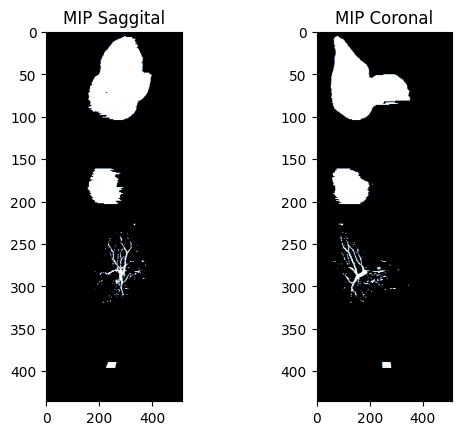

In [56]:
pixel_len_mm = [2.5, 0.781250, 0.781250]

fig, ax = plt.subplots(1, 2)
ax[0].imshow(MIP_sagittal_plane(segmentation_img), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[0].set_title('MIP Saggital')
ax[1].imshow(MIP_coronal_plane(segmentation_img), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[1].set_title('MIP Coronal')
plt.show()

In [48]:
mask=find_centroid(segmentation_img)
img_segment = visualize_axial_slice(dcm_img, segmentation_img, mask)

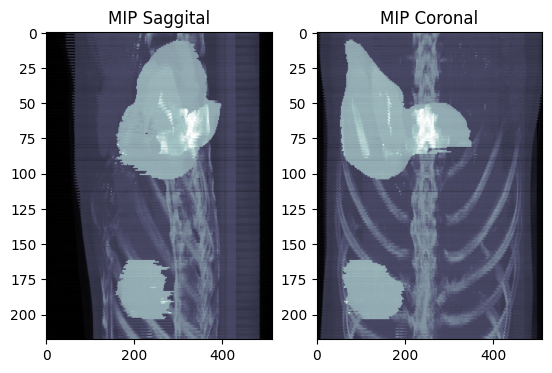

In [49]:
pixel_len_mm = [2.5, 0.781250, 0.781250]

fig, ax = plt.subplots(1, 2)
ax[0].imshow(MIP_sagittal_plane(img_segment), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[0].set_title('MIP Saggital')
ax[1].imshow(MIP_coronal_plane(img_segment), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[1].set_title('MIP Coronal')
plt.show()


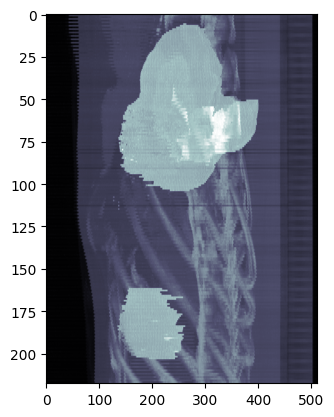

In [55]:
# Create projections varying the angle of rotation
#   Configure visualization colormap
img_min = np.amin(img_segment)
img_max = np.amax(img_segment)
cm = matplotlib.colormaps['bone']
fig, ax = plt.subplots()
#   Configure directory to save results
os.makedirs('results/MIP/', exist_ok=True)
#   Create projections
n = 32
projections = []
for idx, alpha in enumerate(np.linspace(0, 360*(n-1)/n, num=n)):
    rotated_img = rotate_on_axial_plane(img_segment, alpha)
    projection = MIP_sagittal_plane(rotated_img)
    plt.imshow(projection, cmap=cm, vmin=img_min, vmax=img_max, aspect=pixel_len_mm[0] / pixel_len_mm[1])
    plt.savefig(f'results/MIP/Projection_{idx}.png')      # Save animation
    projections.append(projection)  # Save for later animation
# Save and visualize animation
animation_data = [
    [plt.imshow(img, animated=True, cmap=cm, vmin=img_min, vmax=img_max, aspect=pixel_len_mm[0] / pixel_len_mm[1])]
    for img in projections
]


In [6]:
anim = animation.ArtistAnimation(fig, animation_data, interval=50, blit=True)
anim.save('results/MIP/Animation.gif')  # Save animation

## 3D Rigid Coregistration

#### Import libraries and files

In [95]:
import math
import pydicom
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import scipy
from scipy.optimize import least_squares
from skimage import exposure
from scipy.ndimage import zoom
from skimage.feature import canny
from typing import Sequence

dcm_input = []
folder_path = 'Project/RM_Brain_3D-SPGR'

#sort the files according to their names
file_list = sorted(os.listdir(folder_path))


for filename in file_list:
    dataset = pydicom.dcmread(folder_path+"/"+filename)
    # loc = dataset.SliceLocation

    dcm_input.append(np.flip(dataset.pixel_array, axis=1))


# Read the reference image
dcm_reference = pydicom.dcmread('Project/icbm_avg_152_t1_tal_nlin_symmetric_VI.dcm')
img_reference = dcm_reference.pixel_array[6:-6, 6:-7, 6:-6]     #Reshape

# Read the atlas file
dcm_atlas = pydicom.dcmread('Project/AAL3_1mm.dcm')
img_atlas = dcm_atlas.pixel_array[:,:-1,:]



#### Define useful functions

In [65]:
def str_floats(sequence_of_floats: Sequence[float]) -> str:
    if sequence_of_floats is None:
        return '(None)'
    return f'({", ".join([f"{coord:0.02f}" for coord in sequence_of_floats])})'

def str_quaternion(q: tuple[float, float, float, float]) -> str:
    if q is None:
        return '[None]'
    return f'{q[0]} + {q[1]}i + {q[2]}j + {q[3]}k'

def multiply_quaternions(
        q1: tuple[float, float, float, float],
        q2: tuple[float, float, float, float]
        ) -> tuple[float, float, float, float]:
    """ Multiply two quaternions, expressed as (1, i, j, k). """
    return (
        q1[0] * q2[0] - q1[1] * q2[1] - q1[2] * q2[2] - q1[3] * q2[3],
        q1[0] * q2[1] + q1[1] * q2[0] + q1[2] * q2[3] - q1[3] * q2[2],
        q1[0] * q2[2] - q1[1] * q2[3] + q1[2] * q2[0] + q1[3] * q2[1],
        q1[0] * q2[3] + q1[1] * q2[2] - q1[2] * q2[1] + q1[3] * q2[0]
    )

def conjugate_quaternion(
        q: tuple[float, float, float, float]
        ) -> tuple[float, float, float, float]:
    """ Multiply two quaternions, expressed as (1, i, j, k). """
    return (
        q[0], -q[1], -q[2], -q[3]
    )

def translation(
        point: tuple[float, float, float],
        translation_vector: tuple[float, float, float]
        ) -> tuple[float, float, float]:
    """ Perform translation of `point` by `translation_vector`. """
    x, y, z = point
    v1, v2, v3 = translation_vector
    return (x+v1, y+v2, z+v3)

def axial_rotation(
        point: tuple[float, float, float],
        angle_in_rads: float,
        axis_of_rotation: tuple[float, float, float]) -> tuple[float, float, float]:
    """ Perform axial rotation of `point` around `axis_of_rotation` by `angle_in_rads`. """
    x, y, z = point
    v1, v2, v3 = axis_of_rotation
    # Normalize axis of rotation to avoid restrictions on optimizer
    v_norm = math.sqrt(sum([coord ** 2 for coord in [v1, v2, v3]]))
    v1, v2, v3 = v1 / v_norm, v2 / v_norm, v3 / v_norm
    #   Quaternion associated to point.
    p = (0, x, y, z)
    #   Quaternion associated to axial rotation.
    cos, sin = math.cos(angle_in_rads / 2), math.sin(angle_in_rads / 2)
    q = (cos, sin * v1, sin * v2, sin * v3)
    #   Quaternion associated to image point
    q_star = conjugate_quaternion(q)
    p_prime = multiply_quaternions(q, multiply_quaternions(p, q_star))
    #   Interpret as 3D point (i.e. drop first coordinate)
    return p_prime[1], p_prime[2], p_prime[3]

def translation_then_axialrotation(point: tuple[float, float, float], parameters: tuple[float, ...]):
    """ Apply to `point` a translation followed by an axial rotation, both defined by `parameters`. """
    x, y, z = point
    t1, t2, t3, angle_in_rads, v1, v2, v3 = parameters
    # Normalize axis of rotation to avoid restrictions on optimizer
    v_norm = math.sqrt(sum([coord ** 2 for coord in [v1, v2, v3]]))
    v1, v2, v3 = v1/v_norm, v2/v_norm, v3/v_norm
    x, y, z = translation(point=(x, y, z), translation_vector=(t1, t2, t3))
    x, y, z = axial_rotation(point=(x, y, z), angle_in_rads=angle_in_rads, axis_of_rotation=(v1, v2, v3))
    return x, y, z

def screw_displacement(point: tuple[float, float, float], parameters: tuple[float, ...]):
    """ Apply to `point` the screw displacement defined by `parameters`. """
    x, y, z = point
    v1, v2, v3, angle_in_rads, displacement = parameters
    # Normalize axis of rotation to avoid restrictions on optimizer
    v_norm = math.sqrt(sum([coord ** 2 for coord in [v1, v2, v3]]))
    v1, v2, v3 = v1/v_norm, v2/v_norm, v3/v_norm
    x, y, z = translation(point=(x, y, z), translation_vector=(displacement*v1, displacement*v2, displacement*v3))
    x, y, z = axial_rotation(point=(x, y, z), angle_in_rads=angle_in_rads, axis_of_rotation=(v1, v2, v3))
    return x, y, z

def vector_of_residuals(ref_points: np.ndarray, inp_points: np.ndarray) -> np.ndarray:
    """ Given arrays of 3D points with shape (point_idx, 3), compute vector of residuals as their respective distance """
    return np.sqrt(np.sum((ref_points-inp_points)**2, axis=1))

def coregister_landmarks(ref_landmarks: np.ndarray, inp_landmarks: np.ndarray):
    """ Coregister two sets of landmarks using a rigid transformation. """
    initial_parameters = [
        0, 0, 0,    # Translation vector
        0,          # Angle in rads
        1, 0, 0,    # Axis of rotation
    ]
    # Find better initial parameters
    centroid_ref = np.mean(ref_landmarks, axis=0)
    centroid_inp = np.mean(inp_landmarks, axis=0)
    initial_parameters[0] = centroid_ref[0] - centroid_inp[0]
    initial_parameters[1] = centroid_ref[1] - centroid_inp[1]
    initial_parameters[2] = centroid_ref[2] - centroid_inp[2]

    def function_to_minimize(parameters):
        """ Transform input landmarks, then compare with reference landmarks."""
        inp_landmarks_transf = np.asarray([translation_then_axialrotation(point, parameters) for point in inp_landmarks])
        return vector_of_residuals(ref_landmarks, inp_landmarks_transf)

    # Apply least squares optimization
    result = least_squares(
        function_to_minimize,
        x0=initial_parameters,
        verbose=1)
    return result

def get_thalamus_mask(img_atlas: np.ndarray) -> np.ndarray:
    thalamus_mask = np.zeros_like(img_atlas)
    thalamus_mask[(121 <= img_atlas) & (img_atlas <= 150)] = 1
    return thalamus_mask

def preprocess_landmarks(landmarks):
    normalized_landmarks = landmarks / np.max(landmarks)
    preprocessed_landmarks = np.round(normalized_landmarks, 2) * 100
    return preprocessed_landmarks.astype(int)

def find_centroid(mask: np.ndarray) -> np.ndarray:
    idcs = np.where(mask == 1)
    centroid = np.stack([
        np.mean(idcs[0]),
        np.mean(idcs[1]),
        np.mean(idcs[2]),
    ])
    return centroid

def visualize_axial_slice(
        img: np.ndarray,
        mask: np.ndarray,
        mask_centroid: np.ndarray,
        ):
    """ Visualize the axial slice (firs dim.) of a single region with alpha fusion. """
    img_slice = img[mask_centroid[0].astype('int'), :, :]
    mask_slice = mask[mask_centroid[0].astype('int'), :, :]

    cmap = matplotlib.colormaps['bone']
    norm = matplotlib.colors.Normalize(vmin=np.amin(img_slice), vmax=np.amax(img_slice))
    fused_slice = \
        0.5*cmap(norm(img_slice))[..., :3] + \
        0.5*np.stack([mask_slice, np.zeros_like(mask_slice), np.zeros_like(mask_slice)], axis=-1)
    

    return(fused_slice)

def apply_canny(img, sigma):
    """ Apply Canny edge detector to image. """
    return canny(img, sigma=sigma)

def visualize_img_and_edges(grayscale_image, edges_image):
    """ Visualize original image and edges. """
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(grayscale_image)
    ax2.imshow(edges_image)
    fig.show()

def mean_absolute_error(img_input: np.ndarray, img_reference) -> np.ndarray:
    """ Compute the MAE between two images. """
    # Your code here:
    #   ...
    return np.mean(np.abs(img_input - img_reference))

def mean_squared_error(img_input: np.ndarray, img_reference) -> np.ndarray:
    """ Compute the MSE between two images. """
    # Your code here:
    #   ...
    return np.mean((img_input - img_reference)**2)

def mutual_information(img_input: np.ndarray, img_reference) -> np.ndarray:
    """ Compute the Shannon Mutual Information between two images. """
    # Your code here:
    #   ...
    nbins = [10, 10]
    # Compute entropy of each image
    hist = np.histogram(img_input.ravel(), bins=nbins[0])[0]
    prob_distr = hist / np.sum(hist)
    entropy_input = -np.sum(prob_distr * np.log2(prob_distr + 1e-7))  # Why +1e-7?
    hist = np.histogram(img_reference.ravel(), bins=nbins[0])[0]
    prob_distr = hist / np.sum(hist)
    entropy_reference = -np.sum(prob_distr * np.log2(prob_distr + 1e-7))  # Why +1e-7?
    # Compute joint entropy
    joint_hist = np.histogram2d(img_input.ravel(), img_reference.ravel(), bins=nbins)[0]
    prob_distr = joint_hist / np.sum(joint_hist)
    joint_entropy = -np.sum(prob_distr * np.log2(prob_distr + 1e-7))
    # Compute mutual information
    return entropy_input + entropy_reference - joint_entropy



#### Processing

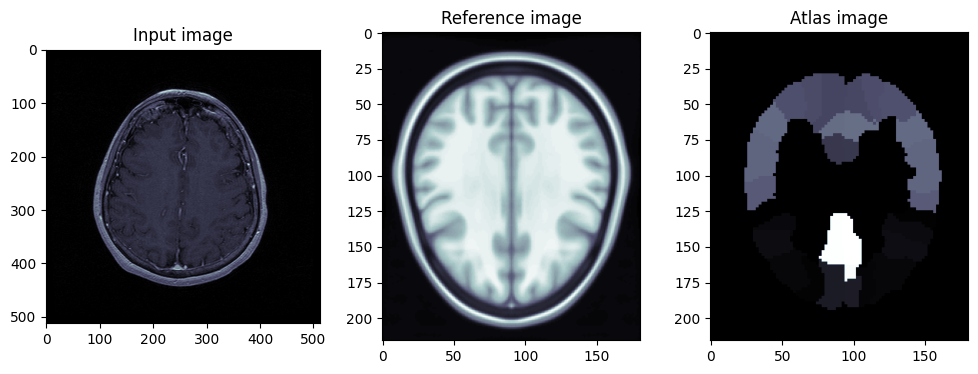

In [96]:
#  Visualize the initial images given
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].imshow(dcm_input[20][:, :], cmap='bone')
ax[1].imshow(img_reference[100, :, :], cmap='bone')
ax[2].imshow(img_atlas[100, :, :], cmap='bone')

ax[0].set_title("Input image")
ax[1].set_title("Reference image")
ax[2].set_title("Atlas image")
plt.show()


The input and reference images are not the same shape

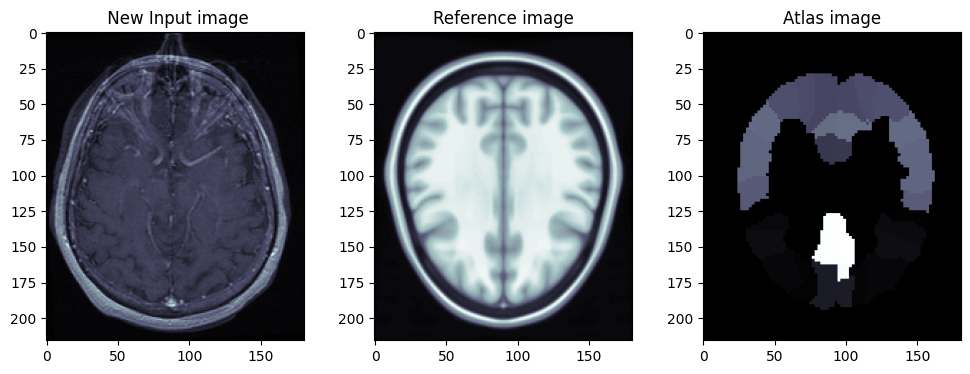

In [97]:
# Reshape and resize the input to match the reference
input = np.array(dcm_input)
crop = input[34:216, 50:455, 80:440]
factors = (181 / crop.shape[0], 216 / crop.shape[1], 181 / crop.shape[2])
resize = zoom(crop, factors, order=1)
rot = rotate_on_axial_plane(resize,3)
img_input=preprocess_landmarks(rot)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].imshow(img_input[20], cmap='bone')
ax[1].imshow(img_reference[100, :, :], cmap='bone')
ax[2].imshow(img_atlas[100, :, :], cmap='bone')
ax[0].set_title(" New Input image")
ax[1].set_title("Reference image")
ax[2].set_title("Atlas image")
plt.show()


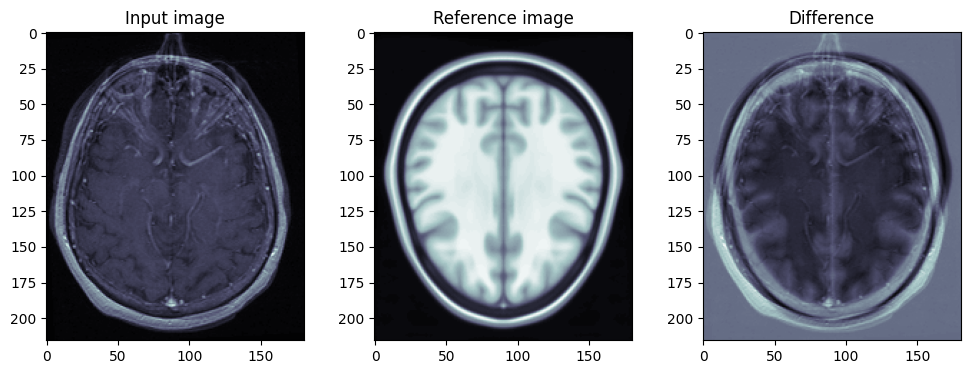

In [98]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
diff = img_input[20] - img_reference[100, :, :]
ax[0].imshow(img_input[20], cmap='bone')
ax[1].imshow(img_reference[100, :, :], cmap='bone')
ax[2].imshow(diff, cmap='bone')

ax[0].set_title("Input image")
ax[1].set_title("Reference image")
ax[2].set_title("Difference")
plt.show()

In [ ]:
landmark_input = img_input[::4, ::4, ::4].reshape(-1,3)
landmark_reference = img_reference[::4, ::4, ::4].reshape(-1, 3)

landmark_inp = img_input.reshape(-1,3)
landmark_ref  = img_reference.reshape(-1,3)


#### Coregistration

In [90]:
# Coregister landmarks
lim = landmark_inp.shape[0]
result = coregister_landmarks(landmark_reference[:lim], landmark_input[:lim])
solution_found = result.x

t1, t2, t3, angle_in_rads, v1, v2, v3 = result.x
print(f'Best parameters:')
print(f'  >> Translation: ({t1:0.02f}, {t2:0.02f}, {t3:0.02f}).')
print(f'  >> Rotation: {angle_in_rads:0.02f} rads around axis ({v1:0.02f}, {v2:0.02f}, {v3:0.02f}).')



The maximum number of function evaluations is exceeded.
Function evaluations 700, initial cost 2.5785e+07, final cost 2.5718e+07, first-order optimality 6.45e+03.
Best parameters:
  >> Translation: (10.79, 9.57, 8.28).
  >> Rotation: 0.41 rads around axis (0.66, 0.48, 0.63).


In [ ]:
# Apply transformations to input landmarks
landmark_inp[:] = np.asarray([translation_then_axialrotation(point, solution_found) for point in landmark_inp[:]])

new_img_input = landmark_inp.reshape(181, 216, 181)


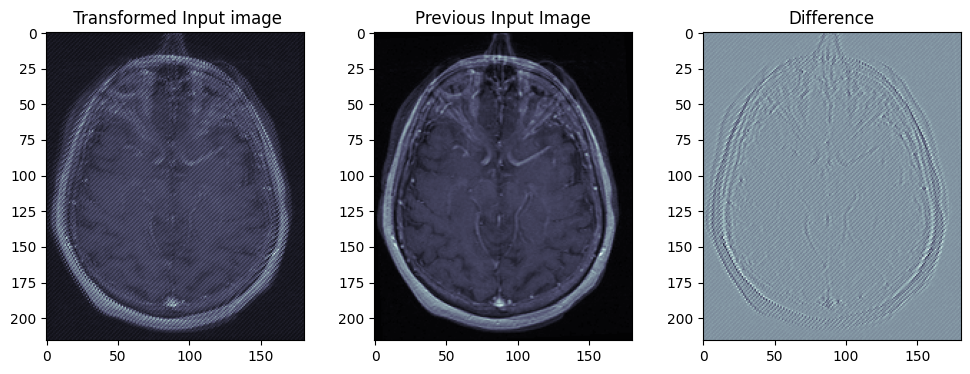

In [99]:

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
diff = new_img_input[20] - img_input[20]
ax[0].imshow(new_img_input[20], cmap='bone')
ax[1].imshow(img_input[20], cmap='bone')
ax[2].imshow(diff, cmap='bone')

ax[0].set_title(" Transformed Input image")
ax[1].set_title("Previous Input Image")
ax[2].set_title("Difference")
plt.show()

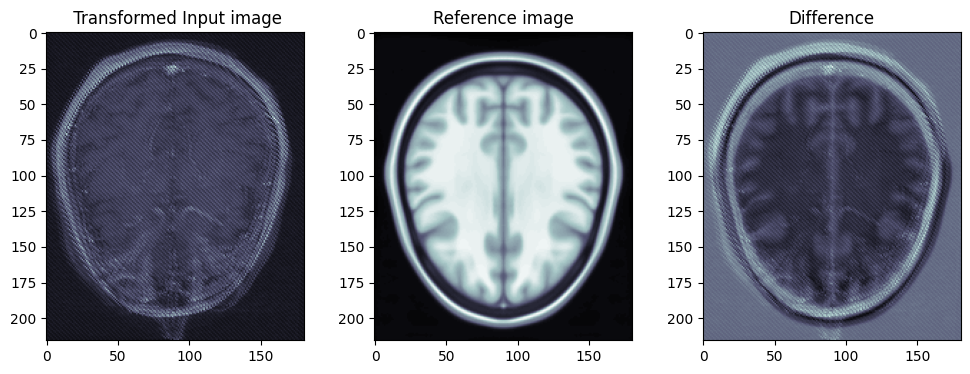

In [107]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
diff = np.flip(new_img_input, axis=1)[20] - img_reference[100, :, :]
ax[0].imshow(np.flip(new_img_input, axis=1)[20], cmap='bone')
ax[1].imshow(img_reference[100, :, :], cmap='bone')
ax[2].imshow(diff, cmap='bone')

ax[0].set_title(" Transformed Input image")
ax[1].set_title("Reference image")
ax[2].set_title("Difference")
plt.show()

#### Validation

In [101]:
# Compute metrics
mae = mean_absolute_error(new_img_input[20], img_reference[100, :, :])
print('MAE:')
print(f'  >> Result: {mae:.02f} HU')

mse = mean_squared_error(new_img_input[20], img_reference[100, :, :])
print('MSE:')
print(f'  >> Result: {mse:.02f} HU^2')

mutual_inf = mutual_information(new_img_input[20], img_reference[100, :, :])
print('Mutual Information:')
print(f'  >> Result: {mutual_inf:02f} bits')


MAE:
  >> Result: 31.24 HU
MSE:
  >> Result: 1409.71 HU^2
Mutual Information:
  >> Result: 0.473573 bits


### Thalamus Region

#### Visualize the Thalamus region on reference space

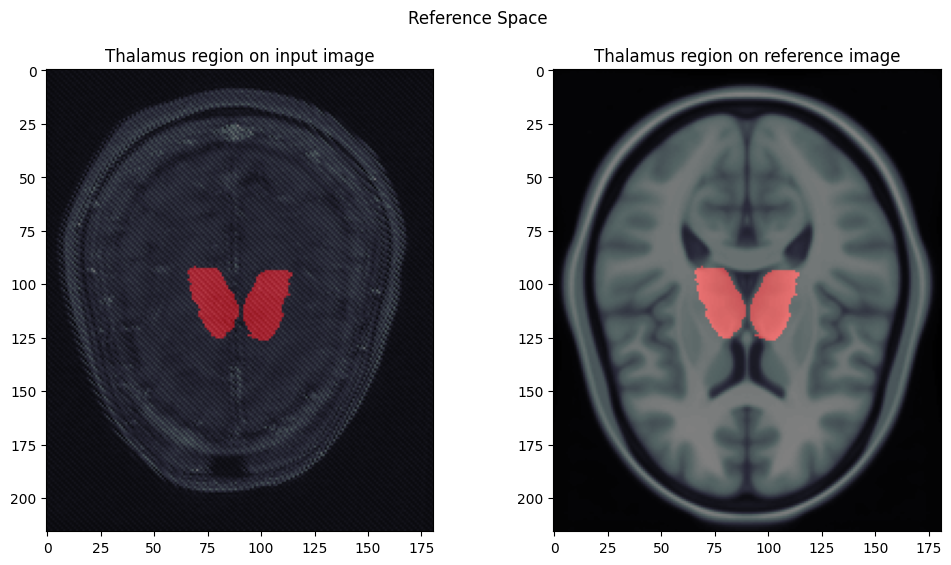

In [103]:
# 

thalamus_mask = get_thalamus_mask(img_atlas)
mask_centroid = find_centroid(thalamus_mask)  
fused_input = visualize_axial_slice(np.flip(new_img_input, axis=1), thalamus_mask, mask_centroid)
fused_ref = visualize_axial_slice(img_reference, thalamus_mask, mask_centroid)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(fused_input, cmap='bone')
ax[1].imshow(fused_ref, cmap='bone')

ax[0].set_title("Thalamus region on input image")
ax[1].set_title("Thalamus region on reference image")
fig.suptitle("Reference Space")
plt.show()

#### Inverse transformation back to input space

In [108]:
# Apply transformations to input landmarks
inv_solution = [-i for i in solution_found]
landmark_inp[:] = np.asarray([translation_then_axialrotation(point, inv_solution) for point in landmark_inp[:]])

img_input_space = landmark_inp.reshape(181, 216, 181)


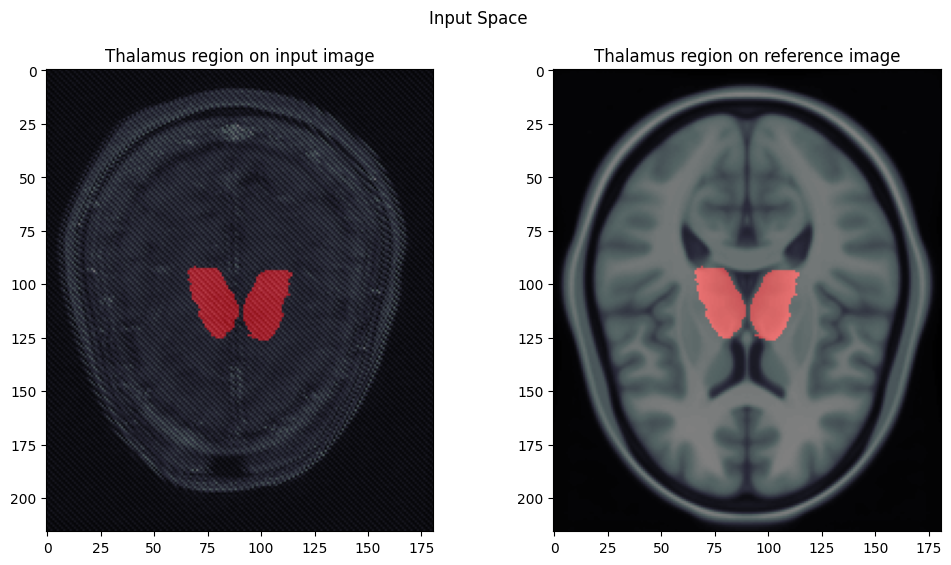

In [110]:

fused_input2 = visualize_axial_slice(np.flip(img_input_space,axis=1), thalamus_mask, mask_centroid)
fused_ref = visualize_axial_slice(img_reference, thalamus_mask, mask_centroid)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(fused_input2, cmap='bone')
ax[1].imshow(fused_ref, cmap='bone')

ax[0].set_title("Thalamus region on input image")
ax[1].set_title("Thalamus region on reference image")
fig.suptitle("Input Space")
plt.show()

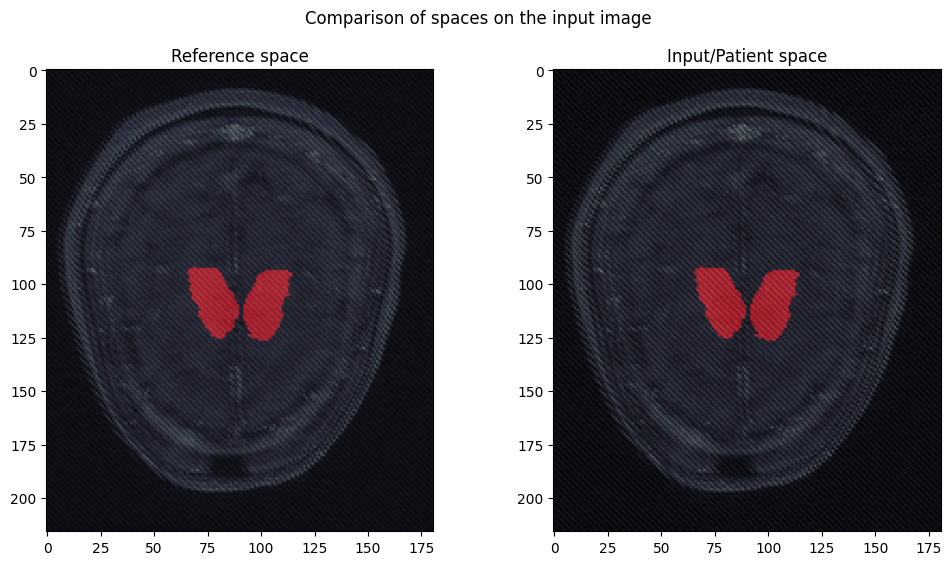

In [111]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(fused_input, cmap='bone')
ax[1].imshow(fused_input2, cmap='bone')

ax[0].set_title("Reference space")
ax[1].set_title("Input/Patient space")
fig.suptitle("Comparison of spaces on the input image")
plt.show()